In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import dill
from scipy.stats import uniform, randint

# preprocessing packages
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# pipeline tools
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, RepeatedKFold
from sklearn.preprocessing import FunctionTransformer

#feature selection
from sklearn.feature_selection import VarianceThreshold, SelectKBest

#models
from sklearn.linear_model import Lasso, Ridge

#metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [38]:
#directory locations
current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
processed_data_folder = parent_directory + '/data/wunderground-com/processed/'
models_folder = parent_directory + '/models/'
images_folder = parent_directory + '/images/'

### Load Data

In [3]:
df = pd.read_csv(processed_data_folder + '1678665697.3855994.txt', 
                 sep = '|')

In [4]:
df.head()

Product_Name Product_Varietal  \
0  Domaine Taupenot-Merme Nuits-Saint-Georges Les...       Pinot Noir   
1   Domaine de la Romanee-Conti Echezeaux Grand Cru        Pinot Noir   
2             Lincourt Rancho Santa Rosa Pinot Noir        Pinot Noir   
3            Domaine Claude Dugat Gevrey-Chambertin        Pinot Noir   
4  Domaine Prieur-Brunet Santenay Maladiere Premi...       Pinot Noir   

                                      Product_Origin Product_Price  \
0  Nuits-St-Georges, Cote de Nuits, Cote d'Or, Bu...        199.99   
1  Flagey-Echezeaux, Cote de Nuits, Cote d'Or, Bu...      3,299.99   
2  Sta. Rita Hills, Santa Barbara, Central Coast,...         40.99   
3  Gevrey-Chambertin, Cote de Nuits, Cote d'Or, B...        179.99   
4  Santenay, Cote de Beaune, Cote d'Or, Burgundy,...         65.99   

  Product_Attributes  User_Avg_Rating  User_Rating_Count  Product_Vintage  \
0           Red Wine              0.0                  0             2017   
1           Red Wine              0.0                  0             2018   
2           Red Wine              4.0                 31             2018   
3           Red Wine              0.0                  0             2020   
4           Red Wine              0.0                  0             2020   

   Critical_Avg_Rating  Critical_Rating_Count  ...  Jan_Min_Low_Wind_Speed   \
0            93.000000                      3  ...                      0.0   
1            95.000000                      4  ...                      0.0   
2            90.666667                      3  ...                      0.0   
3            92.000000                      3  ...                      0.0   
4            92.333333                      3  ...                      0.0   

  Jan_Max_High_Pressure  Jan_Avg_High_Pressure  Jan_Min_High_Pressure  \
0                  29.8              29.493548                   29.1   
1                  29.9              29.384211                   28.9   
2                  30.3              30.135484                   29.9   
3                  29.9              29.558065                   29.0   
4                  29.9              29.558065                   29.0   

   Jan_Avg_Pressure  Jan_Max_Low_Pressure  Jan_Avg_Low_Pressure  \
0         29.416129                  29.8             29.354839   
1         29.252632                  29.8             29.157895   
2         30.064516                  30.2             30.000000   
3         29.477419                  29.9             29.400000   
4         29.477419                  29.9             29.400000   

   Jan_Min_Low_Pressure  Jan_Average_Precipitation  Jan_Total_Precipitation  
0                  28.7                   0.000000                     0.00  
1                  28.8                   0.000000                     0.00  
2                  29.5                   0.087742                     2.72  
3                  28.8                   0.000000                     0.00  
4                  28.8                   0.000000                     0.00  

[5 rows x 456 columns]

In [5]:
df.columns

Index(['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=456)

In [6]:
df.shape

(1115, 456)

### Missing Data & Data Type Correction

In [7]:
df.isnull().sum().sum()

0

### Reduce to Input Data and Assign Predictive and Target Feature

In [8]:
# specifying predictive and target features
X = df.drop(columns = ['Product_Name', 'Product_Varietal', 'Product_Origin', 'Product_Price',
       'Product_Attributes', 'User_Avg_Rating', 'User_Rating_Count',
       'Product_Vintage', 'Critical_Avg_Rating', 'Critical_Rating_Count', 'Appellation_Level', 'Weather_Origin'])
y = df[['Critical_Avg_Rating']]

In [9]:
X.columns

Index(['Aug_Max_High_Temperature', 'Aug_Avg_High_Temperature',
       'Aug_Min_High_Temperature', 'Aug_Avg_Temperature',
       'Aug_Max_Low_Temperature', 'Aug_Avg_Low_Temperature',
       'Aug_Min_Low_Temperature', 'Aug_Max_High_ Dew_Point',
       'Aug_Avg_High_ Dew_Point', 'Aug_Min_High_ Dew_Point',
       ...
       'Jan_Min_Low_Wind_Speed ', 'Jan_Max_High_Pressure',
       'Jan_Avg_High_Pressure', 'Jan_Min_High_Pressure', 'Jan_Avg_Pressure',
       'Jan_Max_Low_Pressure', 'Jan_Avg_Low_Pressure', 'Jan_Min_Low_Pressure',
       'Jan_Average_Precipitation', 'Jan_Total_Precipitation'],
      dtype='object', length=444)

In [10]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Critical_Avg_Rating  1115 non-null   float64
dtypes: float64(1)
memory usage: 8.8 KB


In [11]:
# create holdout set to approximate real-world performance
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=123)

### Linear Models

In [12]:
pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                     ('scaler', StandardScaler()),
                     ('near_zero_variance', VarianceThreshold()),
                     #('k_best', SelectKBest()),
                     ('regressor', None)])

In [13]:
search_space = [{'near_zero_variance__threshold': [0.00, 0.01, 0.05, .10],
                 'regressor': [Lasso(), Ridge()],
                 'regressor__alpha': uniform(0, 1)}]

kfold = RepeatedKFold(n_splits=5,
                      n_repeats=10,
                      random_state=123)

lm = RandomizedSearchCV(pipeline,
                        param_distributions = search_space,
                        n_iter = 200,
                        cv = kfold,
                        scoring ='neg_mean_squared_error',
                        n_jobs = 6,
                        random_state = 123)
lm.fit(X_train, y_train)

print("Best parameter (CV score=%0.3f):" % lm.best_score_)
print(lm.best_params_)

Best parameter (CV score=-3.323):
{'near_zero_variance__threshold': 0.05, 'regressor': Lasso(alpha=0.0432228920796468), 'regressor__alpha': 0.0432228920796468}


### Holdout Performance

In [14]:
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, lm.predict(X_test))
print("Mean Squared Error (MSE):", mse)

Mean Squared Error (MSE): 3.2935234275762406


In [15]:
# Calculate Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, lm.predict(X_test), squared=False)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 1.8148067190685184


In [16]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, lm.predict(X_test))
print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 1.4380987466989499


In [17]:
# Calculate R-squared (R2)
r2 = r2_score(y_test, lm.predict(X_test))
print("R-squared (R2):", r2)

R-squared (R2): 0.0049387435032332005


In [18]:
# Calculate Explained Variance Score (EVS)
evs = explained_variance_score(y_test, lm.predict(X_test))
print("Explained Variance Score (EVS):", evs)

Explained Variance Score (EVS): 0.01254763172000406


### Error Distributions

In [31]:
error_df = pd.DataFrame(y_test, columns = ['Critical_Avg_Rating'])
error_df['y_pred'] = lm.predict(X_test)
error_df['residual'] = error_df['Critical_Avg_Rating'] - error_df['y_pred']

In [32]:
error_df.head()

Critical_Avg_Rating     y_pred  residual
1014            92.000000  92.604857 -0.604857
742             93.750000  92.938219  0.811781
85              91.666667  93.380287 -1.713621
857             92.000000  92.893506 -0.893506
888             91.666667  93.229450 -1.562783

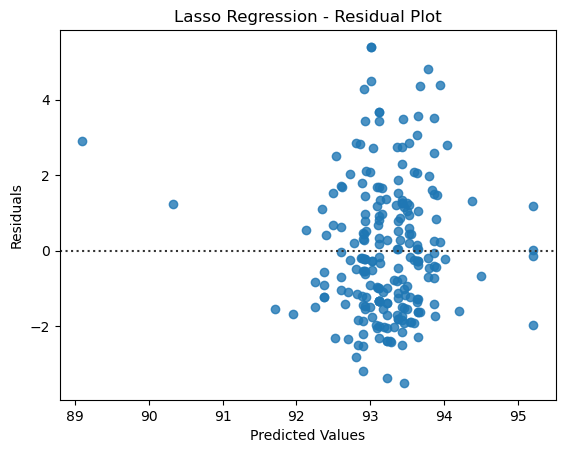

In [36]:
sns.residplot(data = error_df, 
              x = 'y_pred', 
              y = 'residual')
plt.title('Lasso Regression - Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()

In [39]:
plt.savefig(images_folder + 'lasso_regression_residual_plot.png', dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

### Feature Importance

In [26]:
lm_best_pipeline = lm.best_estimator_
importances = np.abs(lm_best_pipeline.named_steps['regressor'].coef_)
indices = np.argsort(importances)[::-1]

In [29]:
n = 20
top_n_indices = indices[:n]
top_n_features = X.columns[top_n_indices]

for feature, importance in zip(top_n_features, importances[top_n_indices]):
    print(feature, "=", importance)

Sep_Max_Low_Humidity = 0.18909954055540643
Nov_Min_High_Wind_Speed  = 0.1690132756029454
Aug_Min_Low_Pressure = 0.1622758756837696
May_Max_High_Humidity = 0.15921767339505033
Dec_Min_Low_Pressure = 0.1492895172034612
Dec_Max_Low_Wind_Speed  = 0.14656332720651521
Feb_Max_High_Temperature = 0.1439533120248341
Dec_Max_High_Wind_Speed  = 0.1322911926778739
Sep_Avg_Low_Wind_Speed  = 0.11711738959745366
May_Min_Low_ Dew_Point = 0.10765104444174835
Jan_Min_Low_Wind_Speed  = 0.10431308201774342
Aug_Min_Low_Humidity = 0.09936206712597406
Mar_Max_High_Wind_Speed  = 0.09887656578828863
May_Max_Low_Temperature = 0.09799267814238725
Sep_Max_High_Temperature = 0.09276737996842313
Nov_Min_Low_Pressure = 0.09247698316457618
Oct_Average_Precipitation = 0.08954300377894234
Jul_Min_Low_Wind_Speed  = 0.08926454534841202
Sep_Min_Low_Wind_Speed  = 0.08783366212430455
Sep_Min_Low_Humidity = 0.0826923370880063


### Write Pipeline to File

In [30]:
with open(models_folder + 'lm_best_cv.pkl', 'wb') as f:
    dill.dump(lm_best_pipeline, f)